In [1]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


from sklearn.linear_model import LinearRegression

In [2]:
df_train = pd.read_pickle("df_train.pkl")
df_validation = pd.read_pickle("df_validation.pkl")
df_test = pd.read_pickle("df_test.pkl")
df_price = pd.read_pickle("df_price.pkl")
df_option = pd.read_pickle("df_merged.pkl")

In [90]:
from sklearn.linear_model import LinearRegression

# **STATISTICAL STRATEGY : exploratory analysis**

As a first step, we use a manual and heuristic statistical approach to study and predict volatility. Instead of using complex mathematical models or machine learning, we build and test alphas based on simple observations, statistical patterns, and market intuition. The core idea is to leverage well-known features of volatility such as clustering, mean reversion, term structure, the gap between implied and realized volatility, and cross-reactions between IV and RV and translate them into tradable signals.

**Advantages**:
- Allows quick exploration of potential behaviors without complex models.
- Builds an initial understanding and intuition of IV vs RV dynamics.
- Strategies are easy to interpret, reproduce, and explain.

**Drawbacks**:
- Can quickly become obsolete, fragile, and unable to capture complex dynamics.
- Limited generalization power.
- Markets often behave counter-intuitively: simple rules like “if volatility goes up, it will keep going up” can be misleading. The most robust signals are sometimes the ones that seem the most counter-intuitive.

### **1st strategy**:

For a given quoted straddle, we look at the absolute log-returns of the last 3 days and the average IV (all maturities) over the same period. 
The strategy that performed best on df_train is the following:

- **LONG signal:**  
  If |log-return| is increasing and IV is also increasing → **LONG**

- **SHORT signal:**  
  If |log-return| is decreasing and IV is also decreasing →  **SHORT**.

In [4]:
def is_sorted(lst):
    return all(lst[i] <= lst[i+1] for i in range(len(lst)-1))

def is_sorted_desc(lst):
    return all(lst[i] >= lst[i+1] for i in range(len(lst)-1))

In [30]:
d1 = {}
d2 = {}
for d in df_train[df_train['Date'] > " 2016-03-01"]['Date'].unique():
    id_date = df_price['Date'].tolist().index(d)
    d1[d] = df_price['Price'].iloc[id_date - 3:id_date+1]
    id_date = df_train.groupby('Date')['IV'].mean().index.tolist().index(d)
    d2[d] = df_train.groupby('Date')['IV'].mean()[id_date - 2:id_date+1]

for d in d1.keys():
    d1[d] = np.abs(np.log(d1[d]/d1[d].shift(1)).dropna())


trade_valid = []
df_fil = df_train[df_train['Date'] > " 2016-03-01"].copy()
for _,row in df_fil.iterrows():
    d = row['Date']
    if (is_sorted(d1[d].tolist())) and (is_sorted(d2[d].tolist())): # LONG 
        trade_valid.append(row['vol_real'] > row['IV'])
    elif (is_sorted_desc(d1[d].tolist())) and (is_sorted_desc(d2[d].tolist())): # SHORT
        trade_valid.append(row['vol_real'] < row['IV'])

print(f"succes of {np.mean(trade_valid) * 100}% on {len(trade_valid)}")

succes of 50.24875621890548% on 603


In [ ]:
d1 = {}
d2 = {}
for d in df_validation[df_validation['Date'] > " 2021-01-27"]['Date'].unique():
    id_date = df_price['Date'].tolist().index(d)
    d1[d] = df_price['Price'].iloc[id_date - 3:id_date+1]
    id_date = df_validation.groupby('Date')['IV'].mean().index.tolist().index(d)
    d2[d] = df_validation.groupby('Date')['IV'].mean()[id_date - 2:id_date+1]

for d in d1.keys():
    d1[d] = np.abs(np.log(d1[d]/d1[d].shift(1)).dropna())

trade_valid = []
df_fil = df_validation[df_validation['Date'] > " 2021-01-27"].copy()
for _,row in df_fil.iterrows():
    d = row['Date']
    if (is_sorted(d1[d].tolist())) and (is_sorted(d2[d].tolist())): # LONG 
        trade_valid.append(row['vol_real'] > row['IV'])
    elif (is_sorted_desc(d1[d].tolist())) and ( is_sorted_desc(d2[d].tolist())): # SHORT
        trade_valid.append(row['vol_real'] < row['IV'])
print(f"succes of {np.mean(trade_valid) * 100}% on {len(trade_valid)}")

succes of 55.46218487394958% on 119


### **2nd strategy**:

For a given quoted straddle, we will study the **term structure** dynamic (how maturity affects IV)

In [86]:
trade_valid = []
df_filtered = df_train[df_train['Date'] > " 2016-03-01"][['Date','day_to_maturity','IV','vol_real']].copy()
for d in df_filtered['Date'].unique().tolist():
    df_date = df_filtered[df_filtered['Date'] == d].sort_values(by='day_to_maturity', ascending=True)
    if is_sorted(df_date['IV'].tolist()):
        list_iv = df_date['IV'].tolist()
        list_rv = df_date['vol_real'].tolist()
        trade_valid = trade_valid + [list_rv[i] > list_iv[i] for i in range(len(df_date))]
print(f"There are {np.mean(trade_valid)*100}% RV>IV (with {len(trade_valid)} straddle) when the term structure is in ASCENDING order")


There are 33.48623853211009% RV>IV (with 872 straddle) when the term structure is in ASCENDING order


In [89]:
trade_valid = []
df_filtered = df_train[df_train['Date'] > " 2016-03-01"][['Date','day_to_maturity','IV','vol_real']].copy()
for d in df_filtered['Date'].unique().tolist():
    df_date = df_filtered[df_filtered['Date'] == d].sort_values(by='day_to_maturity', ascending=True)
    if is_sorted_desc(df_date['IV'].tolist()):
        list_iv = df_date['IV'].tolist()
        list_rv = df_date['vol_real'].tolist()
        trade_valid = trade_valid + [list_rv[i] < list_iv[i] for i in range(len(df_date))]
print(f"There are {np.mean(trade_valid)*100}% RV<IV (with {len(trade_valid)} straddle) when the term structure is in DESCENDING order")


There are 51.01123595505618% RV<IV (with 890 straddle) when the term structure is in DESCENDING order


From the first results, an increasing term structure is a very good indicator for short volatility signals. On dates where the term structure was rising, the IV was often overpriced.
We therefore keep only the following signal:

- **SHORT signal:**  
  If the term structure is increasing → **SHORT**

In [105]:
dic_slope = {}
trade_valid = []
df_filtered = df_train[df_train['Date'] > " 2016-03-01"][['Date','day_to_maturity','IV','vol_real']].copy()
for d in df_filtered['Date'].unique().tolist():
    df_date = df_filtered[df_filtered['Date'] == d].sort_values(by='day_to_maturity', ascending=True)
    if is_sorted(df_date['IV'].tolist()):
        list_iv = df_date['IV'].tolist()
        list_rv = df_date['vol_real'].tolist()
        Y = list_iv
        X = df_date['day_to_maturity'].tolist()

        X = np.array(X).reshape(-1, 1)
        Y = np.array(Y)

        model = LinearRegression()
        model.fit(X, Y)

        dic_slope[d] = model.coef_[0]
        #trade_valid = trade_valid + [list_rv[i] > list_iv[i] for i in range(len(df_date))]

#print(f"There are {np.mean(trade_valid)*100}% RV>IV (with {len(trade_valid)} straddle) when the term structure is in ASCENDING order")


We now try to optimize the short signal. We perform linear regressions on periods with an increasing term structure to identify slope levels that correspond to a robust short signal.

The goal is to find a quantile threshold (threshold) so that the short signal is strong when the slope is above this quantile, among all slopes calculated on df_train.

In [118]:
threshold = 0
trade_valid = []
for d in df_filtered['Date'].unique().tolist():
    df_date = df_filtered[df_filtered['Date'] == d].sort_values(by='day_to_maturity', ascending=True)
    if is_sorted(df_date['IV'].tolist()):
        if dic_slope[d] > np.percentile(list(dic_slope.values()),threshold):
            list_iv = df_date['IV'].tolist()
            list_rv = df_date['vol_real'].tolist()
            trade_valid = trade_valid + [list_rv[i] < list_iv[i] for i in range(len(df_date))]

print(f"There are {np.mean(trade_valid)*100}% RV<IV (with {len(trade_valid)} straddle) when the term structure is in ASCENDING order")


There are 66.3594470046083% RV<IV (with 868 straddle) when the term structure is in ASCENDING order


Let's calibrate the theshold on df_train

In [ ]:
threshold_range = np.arange(0, 1.01, 0.01)  

best_threshold = None
best_rate = -np.inf

dates_unique = df_filtered['Date'].unique().tolist()
dic_slope_values = list(dic_slope.values())

for th in threshold_range:
    trade_valid = []
    for d in dates_unique:
        df_date = df_filtered[df_filtered['Date'] == d].sort_values(by='day_to_maturity')
        if is_sorted(df_date['IV'].tolist()):
            if dic_slope[d] > np.percentile(dic_slope_values, th*100):
                list_iv = df_date['IV'].tolist()
                list_rv = df_date['vol_real'].tolist()
                trade_valid.extend([list_rv[i] < list_iv[i] for i in range(len(df_date))])

    if trade_valid: 
        rate = np.mean(trade_valid)
        print(f"Threshold = {th:.2f}, success rate = {rate*100:.2f}% on {len(trade_valid)} straddles")
        if rate > best_rate:
            best_rate = rate
            best_threshold = th

print(f"\nBest threshold = {best_threshold:.2f} with success rate = {best_rate*100:.2f}%")

Threshold = 0.00, success rate = 66.36% on 868 straddles
Threshold = 0.01, success rate = 66.32% on 864 straddles
Threshold = 0.02, success rate = 66.20% on 855 straddles
Threshold = 0.03, success rate = 66.75% on 845 straddles
Threshold = 0.04, success rate = 66.95% on 835 straddles
Threshold = 0.05, success rate = 66.71% on 826 straddles
Threshold = 0.06, success rate = 66.55% on 822 straddles
Threshold = 0.07, success rate = 66.79% on 813 straddles
Threshold = 0.08, success rate = 66.92% on 804 straddles
Threshold = 0.09, success rate = 66.50% on 794 straddles
Threshold = 0.10, success rate = 66.50% on 785 straddles
Threshold = 0.11, success rate = 66.79% on 780 straddles
Threshold = 0.12, success rate = 66.45% on 772 straddles
Threshold = 0.13, success rate = 66.10% on 764 straddles
Threshold = 0.14, success rate = 66.31% on 754 straddles
Threshold = 0.15, success rate = 66.31% on 745 straddles
Threshold = 0.16, success rate = 66.08% on 740 straddles
Threshold = 0.17, success rate 

After calibration, the threshold seems to have little effect. We will therefore stick with the simple initial strategy.

Let's test the result on df_validation directly on `main.py`

## **3rd strategy**

**We will try a strategy based on the spread : RV(day_to_mat) - IV(day_to_mat historical)**

In [6]:
df_filtered = pd.concat([df_train,df_validation], ignore_index = True)
df_filtered = df_filtered[df_filtered['Date'] > " 2016-03-01"]

In [29]:
def get_prices_list_historical(date, nb_period):
        ''' This function returns the list of spot prices for the nb_period preceding the date 
        provided as a parameter.

        RETURNS
        -------
        type : list
        '''
        list_date = df_price['Date'].tolist()
        id_date = list_date.index(date)
        filtered = df_price.iloc[id_date - nb_period : id_date + 1]
        return filtered['Price'].tolist()

def get_realized_volatility(prices):
    '''This function calculates the annualized realized volatility for a 
    given list of stock prices provided as the parameter prices.

    RETURNS
    -------
    type : float
    '''
    log_returns = np.diff(np.log(prices))
    realized_vol = np.sqrt(np.mean(log_returns ** 2) * 252)
    return realized_vol

In [ ]:
get_realized_volatility(get_prices_list_historical(" 2016-03-02", 30))

0.3506556812075462

In [7]:
df_filtered = df_train[df_train['Date'] > " 2016-03-01"]

In [ ]:
spread_realized1 = [] # among positive historical spread (rv - iv)
spread_realized2 = [] # among negative historical spread (rv - iv)
for _,row in df_filtered.iterrows():
    if get_realized_volatility(get_prices_list_historical(row['Date'],int(row['day_to_maturity']))) > row['IV']:
        spread_realized1.append(row['vol_real'] - row['IV'])
    elif get_realized_volatility(get_prices_list_historical(row['Date'],int(row['day_to_maturity']))) < row['IV']:
        spread_realized2.append(row['vol_real'] - row['IV'])


Statistics on RV - IV when RV_historical(day_to_mat) - IV **>** 0

In [ ]:
pd.Series(spread_realized1).describe()

count    2501.000000
mean        0.004869
std         0.140148
min        -0.335740
25%        -0.060660
50%        -0.028390
75%         0.019330
max         0.790100
dtype: float64

Statistics on RV - IV when RV_historical(day_to_mat) - IV **<** 0

In [18]:
pd.Series(spread_realized2).describe()

count    3462.000000
mean       -0.001687
std         0.086539
min        -0.249800
25%        -0.052853
50%        -0.011175
75%         0.032195
max         0.723810
dtype: float64

In [ ]:
spread = [] # RV(past days) - IV
spread_realized = [] # RV - IV
for _,row in df_filtered.iterrows():
    spread.append(get_realized_volatility(get_prices_list_historical(row['Date'],int(row['day_to_maturity']))) - row['IV'])
    spread_realized.append(row['vol_real'] - row['IV'])

In [26]:
pd.Series(spread).describe()

count    5963.000000
mean       -0.003894
std         0.101483
min        -0.373224
25%        -0.068030
50%        -0.018435
75%         0.048472
max         0.570276
dtype: float64

In [25]:
spread_positif = [i for i in spread if i>0]
spread_negatif = [i for i in spread if i<0]

print(pd.Series(spread_positif).describe())
print(pd.Series(spread_negatif).describe())


count    2501.000000
mean        0.085594
std         0.085768
min         0.000166
25%         0.029263
50%         0.063575
75%         0.109653
max         0.570276
dtype: float64
count    3462.000000
mean       -0.068540
std         0.049601
min        -0.373224
25%        -0.094248
50%        -0.059825
75%        -0.031393
max        -0.000042
dtype: float64


In [46]:
spread_realized_positif = []
spread_realized_negatif = []
for _,row in df_filtered.iterrows():
    spr = get_realized_volatility(get_prices_list_historical(row['Date'],int(row['day_to_maturity']))) - row['IV']
    if (spr in spread_positif) and (spr > np.percentile(spread_positif,90)):
        spread_realized_positif.append(row['vol_real'] - row['IV'])
    elif (spr in spread_negatif) and (spr < np.percentile(spread_negatif,10)):
        spread_realized_negatif.append(row['vol_real'] - row['IV'])

In [ ]:
print(pd.Series(spread_realized_positif).describe()) # Statistic of realized volatility - IV when the spread of historical vol - IV > quantile(0.9) of all positive spread
print(pd.Series(spread_realized_negatif).describe()) # Statistic of realized volatility - IV when the spread of historical vol - IV < quantile(0.1) of all negative spread

count    250.000000
mean       0.001568
std        0.196037
min       -0.246990
25%       -0.106497
50%       -0.047645
75%        0.015195
max        0.790100
dtype: float64
count    347.000000
mean      -0.000978
std        0.087984
min       -0.249800
25%       -0.055890
50%        0.006880
75%        0.058775
max        0.265820
dtype: float64


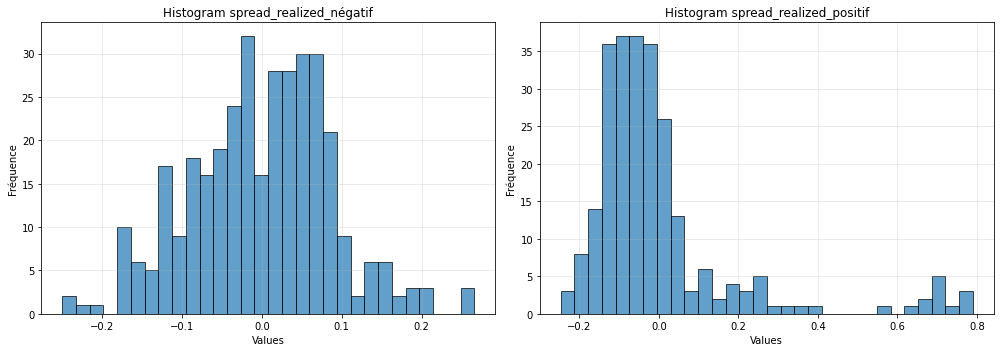

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

axes[0].hist(spread_realized_negatif, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title("Histogram spread_realized_négatif")
axes[0].set_xlabel("Values")
axes[0].set_ylabel("Fréquence")
axes[0].grid(alpha=0.3)

axes[1].hist(spread_realized_positif, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title("Histogram spread_realized_positif")
axes[1].set_xlabel("Values")
axes[1].set_ylabel("Fréquence")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**REMARK** : From the previous statistics, we observe that when historical volatility is significantly higher than implied volatility (i.e., when the spread RV – IV is above the 90th quantile among positive spreads), the option tends to be overpriced.
Conversely, when the spread RV – IV is below the 10th quantile among negative spreads (i.e., when IV is much larger than historical volatility), then IV tends to be underpriced.

These two results are highly against the common intuition.

In [55]:
trade_valid=[]
for _,row in df_filtered.iterrows():
    spr = get_realized_volatility(get_prices_list_historical(row['Date'],int(row['day_to_maturity']))) - row['IV'] # spread 
    if (spr in spread_positif) and (spr > np.percentile(spread_positif,90)): # SHORT
        trade_valid.append(row['vol_real'] < row['IV'])
    elif (spr in spread_negatif) and (spr < np.percentile(spread_negatif,10)): # LONG
        trade_valid.append(row['vol_real'] > row['IV'])
print(f"succes of {np.mean(trade_valid) * 100}% on {len(trade_valid)}")

succes of 59.12897822445561% on 597


We will now try to implement this strategy and backtest it directly in the main backtesting architecture and backtest it on `main.ipynb`

In [82]:
temp = 0
for d in df_train['Date'].unique():
    df_filt = df_train[df_train['Date'] == d]
    if not (all(df_filt['IV'] > df_filt['vol_real']) or all(df_filt['IV'] < df_filt['vol_real'])):
        temp+=1
print(f"there are {temp/len(df_train['Date'].unique()) * 100}% date where not all IV are > or < to RV")

there are 37.71532184950136% date where not all IV are > or < to RV


In [83]:
temp = 0
for d in df_validation['Date'].unique():
    df_filt = df_validation[df_validation['Date'] == d]
    if not (all(df_filt['IV'] > df_filt['vol_real']) or all(df_filt['IV'] < df_filt['vol_real'])):
        temp+=1
print(f"there are {temp/len(df_validation['Date'].unique()) * 100}% date where not all IV are > or < to RV")

there are 34.862385321100916% date where not all IV are > or < to RV
